# Quick Comparisons

In this notebook, we'll run a few quick comparisons between dyadic Louvain, single-stage hypergraph Louvain, and full hypergraph Louvain on the `contact-primary-school` data set. The highlight here is that `hypergraph louvain` can, when initialized with reasonable parameters (as obtained e.g. from a warm start) achieve higher polyadic modularity than dyadic Louvain. This is what we would ideally expect, but it's still nice to see it indeed happening. Additionally, as we would expect, the supernode steps do indeed help. 

The number of nodes is not large, but there's a fairly large number of edges, which may explain the relatively slow computation time. We might have opportunities to do better here. 

Finally, it's worth noting that the modularity of the partition we find is actually higher than that of the true labels, which can be interpreted as either a bug or a feature. 

In [1]:
using Pkg; Pkg.activate(".")
using HypergraphModularity

# using Optim 
using Plots
using TimerOutputs
using RCall
using StatsBase

 Activating environment at `~/codes/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1260


In [2]:
dataset = "contact-primary-school-classes"
kmax_ = 6

H, Z = read_hypergraph_data(dataset,kmax_)

keepdims = [2, 3, 4, 5]

kmax = maximum(keys(H.E))
kmin = minimum(keys(H.E))

for i = 1:kmax
    if !(i ∈ keepdims)
        H.E[i] = Dict()
    end
end

α0 = vcat(repeat([0.0], kmax), 1:kmax)

n = length(H.D)

function ω(p, α)
    k = sum(p)
    return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

Ω = buildΩ(ω, α0, kmax)

(::HypergraphModularity.var"#Ω#8"{HypergraphModularity.var"#Ω#3#9"{typeof(ω),Int64}}) (generic function with 1 method)

In [3]:
for k = keepdims
    p = mean([length(partitionize(Z[e])) == 1 for e in keys(H.E[k])])
    println("k = $k: $(round(100*p, digits = 0)) % of $(length(keys(H.E[k]))) edges are within a single group.")
end

k = 2: 33.0 % of 7748 edges are within a single group.
k = 3: 53.0 % of 4600 edges are within a single group.
k = 4: 46.0 % of 347 edges are within a single group.
k = 5: 11.0 % of 9 edges are within a single group.


# Dyadic Modularity

In [4]:
γ̂ = 10.0
α̂ = α0

timeAlg(expr)= @timed eval(expr)

println("DYADIC")

print(rpad("iteration", 20))
print(rpad("Q (dyadic)", 15))
print(rpad("Q (polyadic)", 15))
print(rpad("γ̂", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  80, "-"))

Ẑ_dyadic = zero(Z)

for i = 1:10
    out = timeAlg(:(CliqueExpansionModularity(H, γ̂, true, true))) # second true adds random scan order
    Ẑ_dyadic = out[1]
    time = out[2]
    
    α̂ = coordinateAscent(H, Ẑ_dyadic, Ω, α̂; n_iters = 10)
    
    Q_D = dyadicModularity(H, Ẑ_dyadic, γ̂)
    Q_H = modularity(H, Ẑ_dyadic, Ω; α = α̂)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q_D, digits = 3))", 15))
    print(rpad("$(round(Q_H, digits = 0))", 15))
    print(rpad("$(round(γ̂, digits = 3))", 15))
    print(rpad("$(length(unique(Ẑ_dyadic)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
    γ̂ = computeDyadicResolutionParameter(H, Ẑ_dyadic)
end

DYADIC
iteration           Q (dyadic)     Q (polyadic)   γ̂             groups    time (s)  
--------------------------------------------------------------------------------
1                   -0.024         -218668.0      10.0           116       2.803     
2                   0.192          -207822.0      3.192          13        0.037     
3                   0.302          -206994.0      2.13           10        0.066     
4                   0.316          -206994.0      2.002          10        0.036     
5                   0.316          -206994.0      2.002          10        0.033     
6                   0.316          -206994.0      2.002          10        0.062     
7                   0.316          -206994.0      2.002          10        0.045     
8                   0.316          -206994.0      2.002          10        0.062     
9                   0.316          -206994.0      2.002          10        0.035     
10                  0.314          -207409.0      2.

# Polyadic Modularity

In [5]:
α̂ = vcat(.5 .+ ((1/2).*1:kmax), repeat([1.4], kmax)) 

println("POLYADIC")

print(rpad("iteration", 20))
print(rpad("Q", 15))
print(rpad("groups", 10))
println(rpad("time (s)", 10))
println(rpad("",  65, "-"))

Ẑ = zero(Z)

for i = 1:10
    out = timeAlg(:(SuperNodeLouvain(H,kmax,Ω;α=α̂, verbose=false, scan_order ="random")))
    Ẑ = out[1]
    time = out[2]
    
    
    α̂ = coordinateAscent(H, Ẑ, Ω, α̂; n_iters = 10)
    Q = modularity(H, Ẑ, Ω; α = α̂)
    
    print(rpad("$i", 20))
    print(rpad("$(round(Q, digits = 0))", 15))
    print(rpad("$(length(unique(Ẑ)))", 10))
    println(rpad("$(round(time; digits=3))", 10))
end

POLYADIC
iteration           Q              groups    time (s)  
-----------------------------------------------------------------
1                   -207597.0      12        13.735    
2                   -206994.0      10        7.993     
3                   -206994.0      10        8.197     
4                   -206994.0      10        8.15      
5                   -207305.0      10        7.893     
6                   -207305.0      10        7.616     
7                   -207305.0      10        9.097     
8                   -207305.0      10        7.208     
9                   -206994.0      10        8.42      
10                  -206994.0      10        8.347     


# Figures (trying RCall)

In [6]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 600, :height => 300))

Ptr{VecSxp} @0x00007fc1c357a998

In [7]:
#using RCall

R"""
library(tidyverse)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.2
│ ✔ tidyr   1.1.2     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/arb/.julia/packages/RCall/jOnwc/src/io.jl:160


RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "stats"     "graphics"  "grDevices"
[13] "utils"     "datasets"  "methods"   "base"     


In [10]:
R"""
df <- tibble(Dyadic = $Ẑ_dyadic, Polyadic = $Ẑ, labels = $Z)

labels <- read_csv("data/contact-primary-school-classes/label-names-contact-primary-school-classes.txt",
                    col_names = FALSE) %>% 
          mutate(num = row_number()) %>% 
          rename(class = X1)

labels
df <- df %>% 
    left_join(labels, by = c("labels" = "num"))

df <- df %>% 
    select(-labels) %>% 
    pivot_longer(-class) %>% 
    rename(method = name) %>% 
    group_by(method) %>% 
    group_by(class, method, value) %>% 
    summarise(n = n()) %>% 
    ungroup()
""";

# Getting there, need to figure out the right way to reorder the labels

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   X1 = col_character()
│ )
└ @ RCall /Users/arb/.julia/packages/RCall/jOnwc/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'class', 'method' (override with `.groups` argument)
└ @ RCall /Users/arb/.julia/packages/RCall/jOnwc/src/io.jl:160


In [11]:
R"""
reorder_df <- df %>% 
    group_by(class, method) %>% 
    summarise(main_group = max(value)) %>% 
    arrange(method, class) %>% 
    ungroup() %>%
    group_by(method) %>% 
    mutate(gr = (!duplicated(main_group)),
           new_number = cumsum(gr)) %>% 
    select(-class) %>% 
    filter(gr) %>%
    print(n = 22)
""";

# A tibble: 19 x 4
# Groups:   method [2]
   method   main_group gr    new_number
   <chr>         <int> <lgl>      <int>
 1 Dyadic            1 TRUE           1
 2 Dyadic            4 TRUE           2
 3 Dyadic            7 TRUE           3
 4 Dyadic            9 TRUE           4
 5 Dyadic            8 TRUE           5
 6 Dyadic            3 TRUE           6
 7 Dyadic            5 TRUE           7
 8 Dyadic            2 TRUE           8
 9 Dyadic            6 TRUE           9
10 Polyadic          5 TRUE           1
11 Polyadic          3 TRUE           2
12 Polyadic          8 TRUE           3
13 Polyadic         10 TRUE           4
14 Polyadic          4 TRUE           5
15 Polyadic          1 TRUE           6
16 Polyadic          6 TRUE           7
17 Polyadic          2 TRUE           8
18 Polyadic          7 TRUE           9
19 Polyadic          9 TRUE          10


┌ Warning: RCall.jl: `summarise()` regrouping output by 'class' (override with `.groups` argument)
└ @ RCall /Users/arb/.julia/packages/RCall/jOnwc/src/io.jl:160


In [12]:
R"""
df <- df %>% 
    left_join(reorder_df, by = c("method" = "method", "value" = "main_group"))
""";

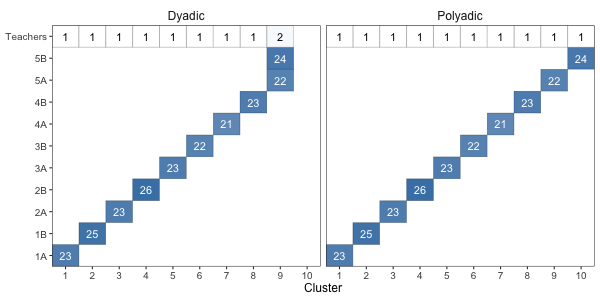

RObject{VecSxp}


In [13]:
R"""

df %>% 
    ggplot() + 
    aes(x = new_number, y = class) + 
    facet_wrap(~method) + 
    geom_tile(aes(fill = n), color = "black") + 
    theme_bw() + 
    geom_text(aes(label = n, color = n > 3)) + 
    scale_color_manual(values = c("black", "white")) + 
    theme(panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(), 
          strip.background = element_blank(),
          strip.text = element_text(size = 12),
          axis.title.x = element_text(size = 12),
          axis.title.y = element_blank(),
          axis.text.x = element_text(size = 10),
          axis.text.y = element_text(size = 10)) + 
    guides(color = FALSE, fill = FALSE) + 
    scale_x_continuous(expand = c(0,0), breaks = 1:10, labels = 1:10) + 
    scale_y_discrete(expand = c(0,0)) + 
    xlab("Cluster") + 
    ylab("Class") + 
    scale_fill_gradient(low = "white", high = "steelblue")
"""

In [14]:
R"""
ggsave("fig/contact-primary-school-clustering.png", width = 6, height = 3, dpi = 200)
""";